## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten,Conv2D,MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from scipy.ndimage import gaussian_filter
import scipy
import seaborn as sns
from itertools import chain
from skimage.io import imread,imshow
import matplotlib.image as mpimg #read png files
from random import sample
import sklearn.model_selection as skl

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, plot_precision_recall_curve, average_precision_score, accuracy_score


## Do some early processing of your metadata for easier model training:

In [2]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
47232,00012021_014.png,No Finding,14,12021,25,M,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012021_014.png
47588,00012087_000.png,No Finding,0,12087,71,F,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00012087_000.png
96808,00025527_000.png,Infiltration,0,25527,67,F,PA,2806,2869,0.143,0.143,NaN,/data/images_011/images/00025527_000.png


In [3]:
## Split up 'finding labels' column so that one column /desease in all_labels dataframe


# all unique diseass in 'finding labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print(all_labels)


# create new column for each disease
for label in all_labels:
    if len(label) > 1:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
all_xray_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Create a newcolumn called 'pneumonia_class' that allow us to look binary classification
## of pneumonia as positive or negative

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})

all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Positive
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative


## Create your training and testing data:

In [5]:
def create_splits(all_xray_df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data=skl.train_test_split(all_xray_df,
                                              test_size=0.2,
                                             stratify=all_xray_df['Pneumonia'])
    
    #balance train_data
    p_ind=train_data[train_data['pneumonia_class']=='Positive'].index.tolist()
    n_ind=train_data[train_data['pneumonia_class']=='Negative'].index.tolist()
    n_sample = sample(n_ind,len(p_ind))
    train_data=train_data.loc[p_ind+n_sample]
    
    """balance val_data.  In the clinical setting where this algorithm will be deployed, 
    patients are being x-rayed based on their clinical symptoms that make Pneumonia 
    highly likely.  The prevalence of Pneumonia is about 20% of those who are x-rayed."""
    vp_ind=val_data[val_data['pneumonia_class']=='Positive'].index.tolist()
    vn_ind=val_data[val_data['pneumonia_class']=='Negative'].index.tolist()
    vn_sample = sample(vn_ind,4*len(vp_ind))
    val_data=val_data.loc[vp_ind+vn_sample]
    
    return train_data, val_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
#Image size
IMG_SIZE = (512, 512)

In [7]:
def my_image_augmentation(train = True):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    if train == True:
        my_idg = ImageDataGenerator(rescale = 1 / 255.,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   rotation_range=20,
                                   shear_range=0.1,
                                   zoom_range=0.5
                                   )
    else:
        my_idg = ImageDataGenerator(rescale = 1 / 255.)
    
    return my_idg


def make_train_gen(train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    my_train_idg = my_image_augmentation(train = True)
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df,
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = IMG_SIZE, 
                                                 batch_size = 32
                                                )
   

    return train_gen


def make_val_gen(val_df):
    my_val_idg = my_image_augmentation(train = False)
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = 64
                                            ) 
    
    
    return val_gen

In [8]:
train_df, val_df = create_splits(all_xray_df)

In [9]:
train_df['Pneumonia'].value_counts()

0.0    1145
1.0    1145
Name: Pneumonia, dtype: int64

In [10]:
val_df['Pneumonia'].value_counts()

0.0    1144
1.0     286
Name: Pneumonia, dtype: int64

In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_gen = make_train_gen(train_df)

val_gen = make_val_gen(val_df)

valX, valY = val_gen.next()

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


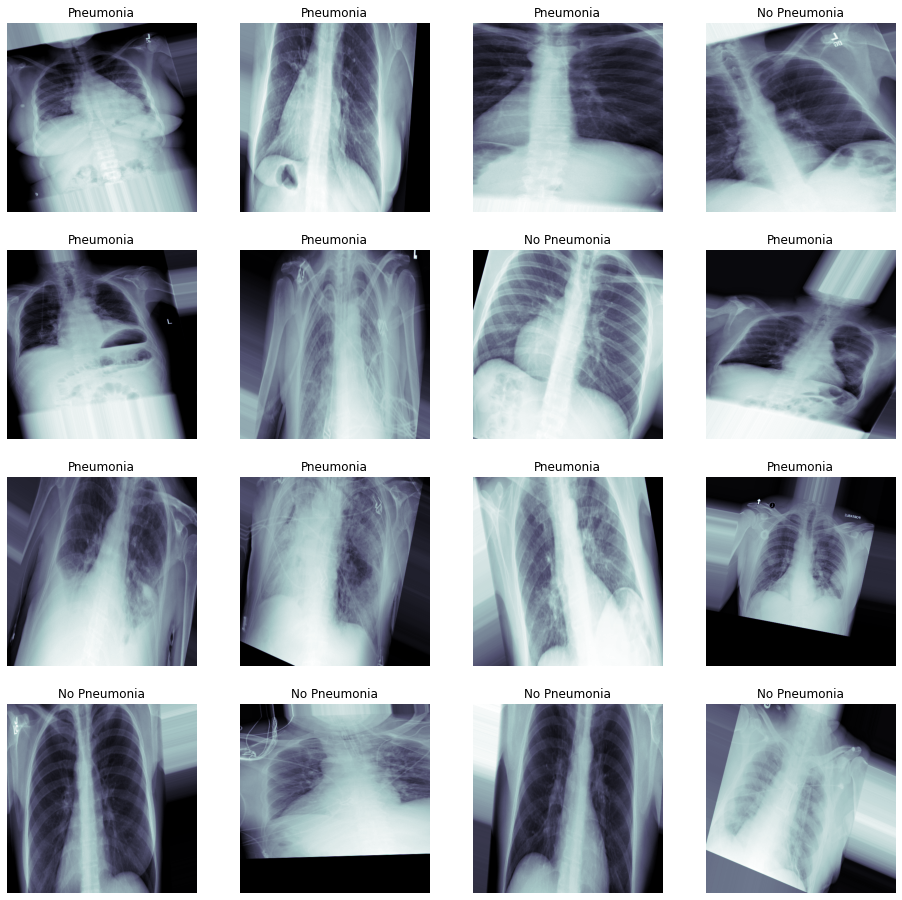

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
model = VGG16(include_top=False, weights='imagenet')
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [14]:
def load_pretrained_model():
    
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
   
    
    return vgg_model


In [42]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    vgg_model = load_pretrained_model()
    
    for layer in vgg_model.layers[:17]:
        layer.trainable = False
        
    my_model = Sequential()
    
    my_model.add(vgg_model)
    
    my_model.add(GlobalAveragePooling2D())
    
    my_model.add(Dense(256, activation='relu'))
    
    my_model.add(BatchNormalization())
    
    my_model.add(Dropout(0.4))
    
    my_model.add(Dense(64, activation='relu'))
    
    my_model.add(BatchNormalization())
    
    my_model.add(Dropout(0.3))
    
    my_model.add(Dense(32, activation='relu'))
    
    my_model.add(BatchNormalization())
    
    my_model.add(Dropout(0.3))
    
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [43]:
optimizer = Adam(lr=3e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [44]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting


weight_path="{}_my_model.best.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss',#CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min',#CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                              save_weights_only = False
                            )

early = EarlyStopping(monitor= 'val_loss',#SAME_AS_METRIC_CHOSEN_ABOVE, 
                       mode= 'min',#CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                       patience=10)

callbacks_list = [checkpoint, early]

my_model = build_my_model()

my_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

### Start training! 

In [45]:
## train your model

# Todo
history = my_model.fit_generator(train_gen, 
                                 validation_data = val_gen, 
                                 epochs = 10, 
                                 callbacks = callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 72 steps, validate for 23 steps
Epoch 1/10
71/72 [============================>.] - ETA: 2s - loss: 0.8804 - binary_accuracy: 0.5248
Epoch 00001: val_loss improved from inf to 0.50465, saving model to xray_class_my_model.best.hdf5
72/72 [==============================] - 236s 3s/step - loss: 0.8794 - binary_accuracy: 0.5240 - val_loss: 0.5047 - val_binary_accuracy: 0.8000
Epoch 2/10
71/72 [============================>.] - ETA: 2s - loss: 0.8338 - binary_accuracy: 0.5310
Epoch 00002: val_loss did not improve from 0.50465
72/72 [==============================] - 234s 3s/step - loss: 0.8324 - binary_accuracy: 0.5319 - val_loss: 0.6767 - val_binary_accuracy: 0.6161
Epoch 3/10
71/72 [============================>.] - ETA: 2s - loss: 0.7956 - binary_accuracy: 0.5337
Epoch 00003: val_loss did not improve from 0.50465
72/72 [==============================] - 229s 3s/step - loss: 0.7962 - binary_accuracy: 0.5341 - val_loss: 0.5613 - v

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [46]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 3s 50ms/sample


In [47]:
def plot_auc(t_y, p_y):
    fpr, tpr, _ = roc_curve(t_y, p_y, pos_label = 1)
    plt.figure(figsize = (14, 10))
    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label = f"Pneumonia AUC Score: {auc(fpr, tpr)}")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-Curve')
    plt.legend()

    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    ## other performance statistics methods

    
def plot_precision_recall_curve(gt, prob):
    
    precision, recall, threshold = precision_recall_curve(gt, prob, pos_label = 1)
    
    plt.figure(figsize = (14, 10))
    plt.style.use("ggplot")
    plt.plot(recall, precision, label =  f"Pneumonia AP Score: {average_precision_score(gt, prob)}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-Curve')
    plt.legend()
    
def f1_score(p, r):
    if(p == 0 or r == 0):
        return 0
    return 2 * p * r / (p + r)
    
    return


    
#Also consider plotting the history of your model training:

def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize = (12, 5))
    axs = axs.flatten()
    plt.style.use("ggplot")
    N = len(history.history["loss"])
    
    axs[0].plot(np.arange(N), history.history["loss"], label = 'train_loss')
    axs[0].plot(np.arange(N), history.history["val_loss"], label = 'val_loss')
    axs[0].set_xlabel('# epochs')
    axs[0].set_ylabel('loss')
    axs[0].set_title('Loss curve')
    axs[0].legend()
    
    axs[1].plot(np.arange(N), history.history["binary_accuracy"], label = 'train_binary_accuracy')
    axs[1].plot(np.arange(N), history.history["val_binary_accuracy"], label = 'val_binary_accuracy')
    axs[1].set_xlabel('# epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Accuracy curve')
    axs[1].legend()
    return

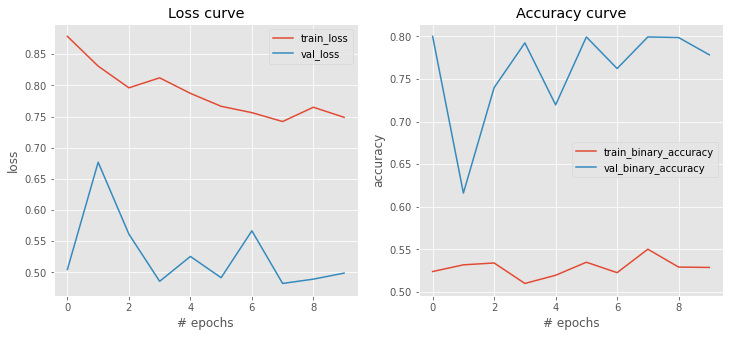

In [48]:
## plot history
plot_history(history)

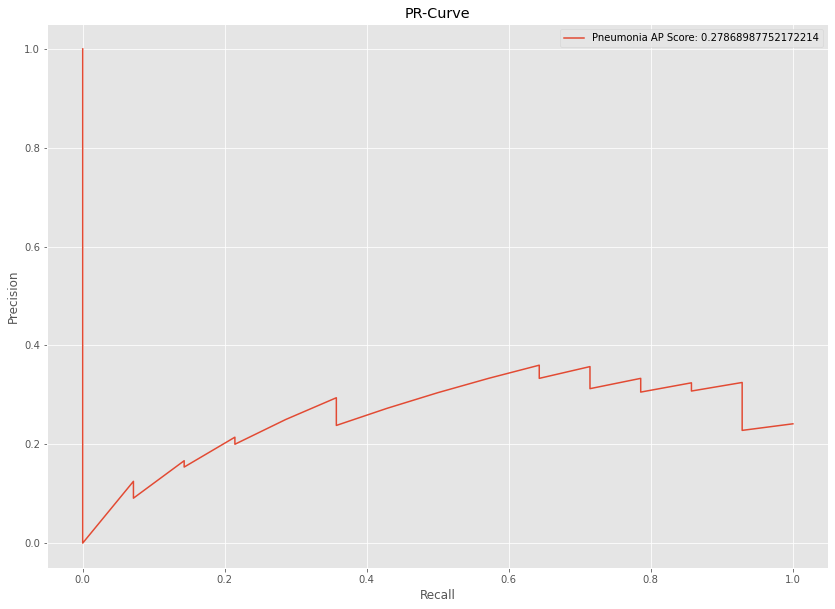

In [49]:
plot_precision_recall_curve(valY, pred_Y)

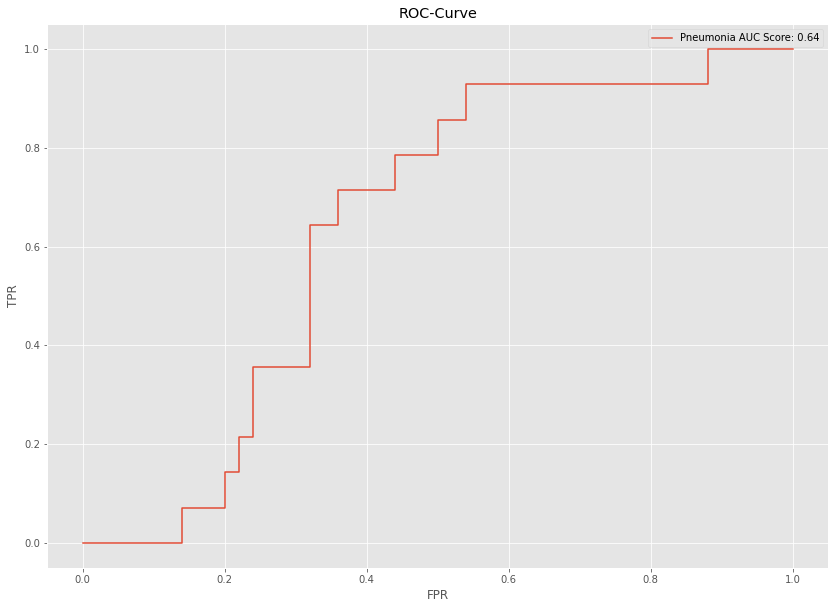

In [50]:
plot_auc(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [51]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, threshold = precision_recall_curve(valY, pred_Y.ravel())
f1_scores = [f1_score(precision[i], recall[i]) for i in range(len(threshold))]

Text(0.5, 1.0, 'F1-score for different thresholds')

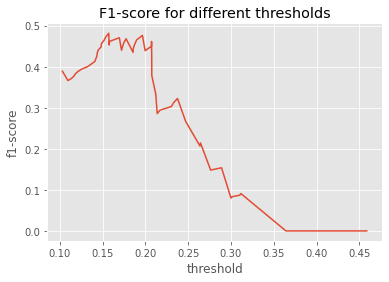

In [52]:
plt.figure()
plt.style.use("ggplot")
plt.plot(threshold, f1_scores)
plt.xlabel('threshold')
plt.ylabel('f1-score')
plt.title('F1-score for different thresholds')

In [53]:
thresh_idx = np.argmax(f1_scores)
my_threshold = threshold[thresh_idx]
print(f"Precision at {my_threshold} threshold is {precision[thresh_idx]}.")
print(f"Recall at {my_threshold} threshold is {recall[thresh_idx]}.")
print(f"F1 score at {my_threshold} threshold is {f1_scores[thresh_idx]}.")

Precision at 0.15699854493141174 threshold is 0.325.
Recall at 0.15699854493141174 threshold is 0.9285714285714286.
F1 score at 0.15699854493141174 threshold is 0.48148148148148157.


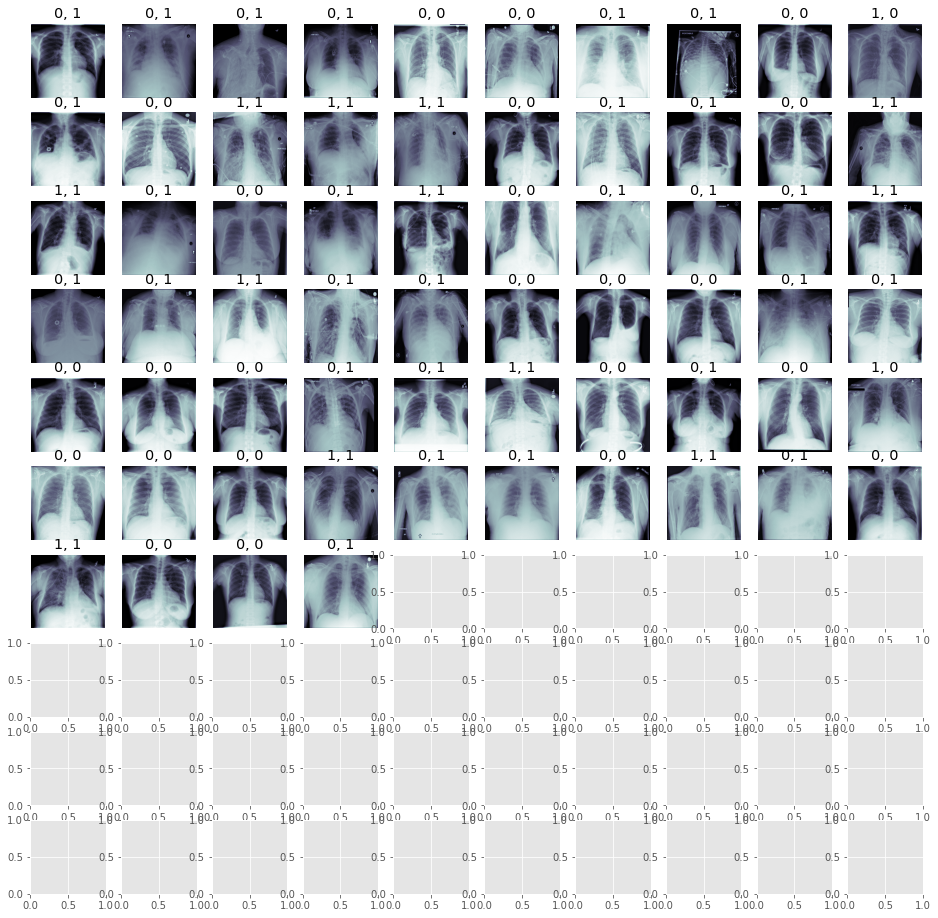

In [54]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1:
        if pred_Y[i] > my_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > my_threshold:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [55]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)